In [1]:
import torch
import torchvision
from torch.utils.data import DataLoader
from matplotlib import pyplot as plt
import torchvision.transforms as transforms

device = torch.device(
    "cuda" if torch.cuda.is_available()
    else "mps" if torch.backends.mps.is_available()
    else "cpu"
)
print(f'Using device: {device}')

Using device: cuda


In [2]:
from AE import ConvAE, train_AE
from diffusion import DiffusionNet, train_diffusion, sample, compute_latent_stats

In [3]:
transform = transforms.Compose([
    transforms.ToTensor(),
])

dataset = torchvision.datasets.MNIST(
    root="mnist/",
    train=True,
    download=True,
    transform=transform
)

In [4]:
train_dataloader = DataLoader(dataset, batch_size=8)

Input shape: torch.Size([8, 1, 28, 28])
Labels: tensor([5, 0, 4, 1, 9, 2, 1, 3])


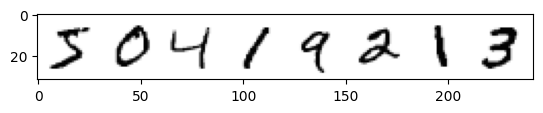

In [5]:
x, y = next(iter(train_dataloader))
print('Input shape:', x.shape)
print('Labels:', y)
plt.imshow(torchvision.utils.make_grid(x)[0], cmap='Greys');

In [6]:
train_dataloader = DataLoader(dataset, batch_size=2048, shuffle=True, pin_memory=True,
                              num_workers=8, persistent_workers=True)

In [7]:
# hyperparameters
latent_channels = 8  # token_dim — must match AE
hidden_size = 256  # internal transformer width for diffusion
T = 100  # diffusion timesteps
n_layers = 6  # transformer layers
n_heads = 8  # attention heads (hidden_size / n_heads = 32 per head)
mlp_size = 512  # FFN intermediate size
dropout_rate = 0.05
lr_ae = 1e-3
lr_diff = 3e-4
ae_epochs = 20
diff_epochs = 100

In [8]:
model_AE = ConvAE(latent_channels=latent_channels)
print(f"ConvAE: {model_AE.n_tokens} tokens x {model_AE.token_dim} dim")

ConvAE: 49 tokens x 8 dim


In [9]:
train_AE(model_AE, ae_epochs, train_dataloader, lr=lr_ae, device=device)

epoch 1/20 done - avg loss=0.5501
epoch 2/20 done - avg loss=0.3249
epoch 3/20 done - avg loss=0.1820
epoch 4/20 done - avg loss=0.1460
epoch 5/20 done - avg loss=0.1163
epoch 6/20 done - avg loss=0.0972
epoch 7/20 done - avg loss=0.0878
epoch 8/20 done - avg loss=0.0827
epoch 9/20 done - avg loss=0.0794
epoch 10/20 done - avg loss=0.0771
epoch 11/20 done - avg loss=0.0753
epoch 12/20 done - avg loss=0.0739
epoch 13/20 done - avg loss=0.0727
epoch 14/20 done - avg loss=0.0716
epoch 15/20 done - avg loss=0.0708
epoch 16/20 done - avg loss=0.0700
epoch 17/20 done - avg loss=0.0694
epoch 18/20 done - avg loss=0.0688
epoch 19/20 done - avg loss=0.0683
epoch 20/20 done - avg loss=0.0679


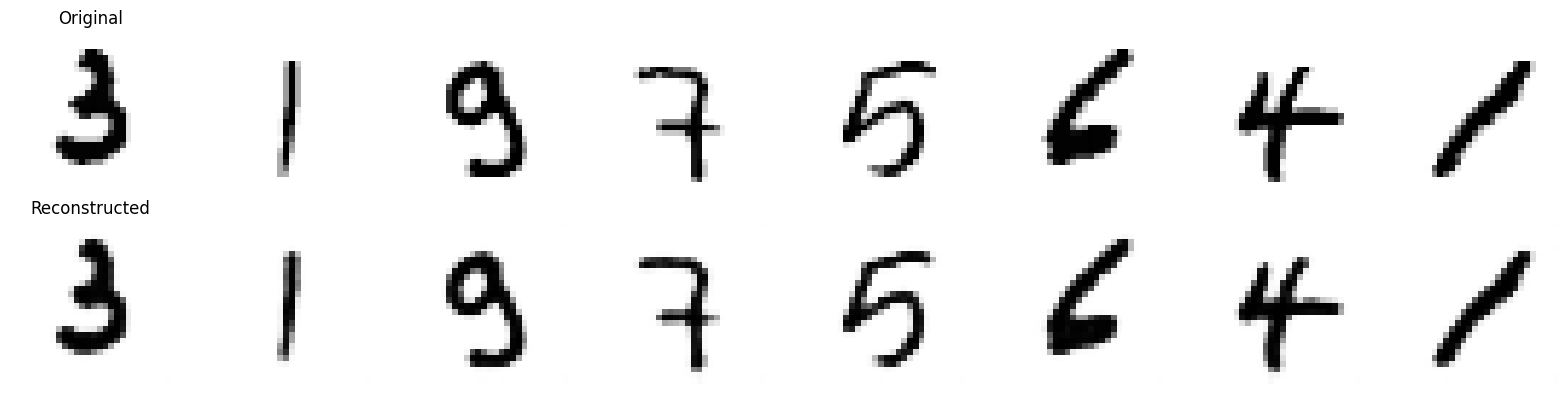

In [10]:
# visualize AE reconstructions
model_AE.eval()
with torch.no_grad():
    x_sample, _ = next(iter(train_dataloader))
    x_sample = x_sample[:8].to(device)
    recon, _ = model_AE(x_sample)
    recon = torch.sigmoid(recon)

fig, axes = plt.subplots(2, 8, figsize=(16, 4))
for i in range(8):
    axes[0, i].imshow(x_sample[i, 0].detach().cpu(), cmap='Greys')
    axes[0, i].axis('off')
    axes[1, i].imshow(recon[i, 0].detach().cpu(), cmap='Greys')
    axes[1, i].axis('off')
axes[0, 0].set_title('Original')
axes[1, 0].set_title('Reconstructed')
plt.tight_layout()

In [11]:
# compute latent stats for normalization
latent_mean, latent_std = compute_latent_stats(model_AE, train_dataloader, device)
print(f"Latent mean range: [{latent_mean.min():.3f}, {latent_mean.max():.3f}]")
print(f"Latent std range:  [{latent_std.min():.3f}, {latent_std.max():.3f}]")

Latent mean range: [-5.815, 4.198]
Latent std range:  [1.124, 2.115]


In [12]:
# smaller batch size for diffusion = more gradient steps per epoch
diff_dataloader = DataLoader(dataset, batch_size=1024, shuffle=True, pin_memory=True,
                              num_workers=8, persistent_workers=True)

In [13]:
diff_model = DiffusionNet(
    token_dim=latent_channels,
    hidden_size=hidden_size,
    n_layers=n_layers,
    n_heads=n_heads,
    dropout_rate=dropout_rate,
    mlp_size=mlp_size,
    T=T,
)
print(f"DiffusionNet params: {sum(p.numel() for p in diff_model.parameters()):,}")

DiffusionNet params: 6,186,504


In [14]:
raw_state = train_diffusion(diff_model, model_AE, diff_epochs, diff_dataloader, T, lr=lr_diff,
                            latent_mean=latent_mean, latent_std=latent_std, device=device)
# diff_model now has EMA weights; raw_state holds the raw training weights

epoch 1/100 done - avg loss=0.4254
epoch 2/100 done - avg loss=0.2052
epoch 3/100 done - avg loss=0.1495
epoch 4/100 done - avg loss=0.1246
epoch 5/100 done - avg loss=0.1115
epoch 6/100 done - avg loss=0.1045
epoch 7/100 done - avg loss=0.0996
epoch 8/100 done - avg loss=0.0958
epoch 9/100 done - avg loss=0.0930
epoch 10/100 done - avg loss=0.0906
epoch 11/100 done - avg loss=0.0897
epoch 12/100 done - avg loss=0.0877
epoch 13/100 done - avg loss=0.0863
epoch 14/100 done - avg loss=0.0843
epoch 15/100 done - avg loss=0.0839
epoch 16/100 done - avg loss=0.0830
epoch 17/100 done - avg loss=0.0823
epoch 18/100 done - avg loss=0.0810
epoch 19/100 done - avg loss=0.0805
epoch 20/100 done - avg loss=0.0807
epoch 21/100 done - avg loss=0.0790
epoch 22/100 done - avg loss=0.0791
epoch 23/100 done - avg loss=0.0781
epoch 24/100 done - avg loss=0.0774
epoch 25/100 done - avg loss=0.0773
epoch 26/100 done - avg loss=0.0769
epoch 27/100 done - avg loss=0.0764
epoch 28/100 done - avg loss=0.0755
e

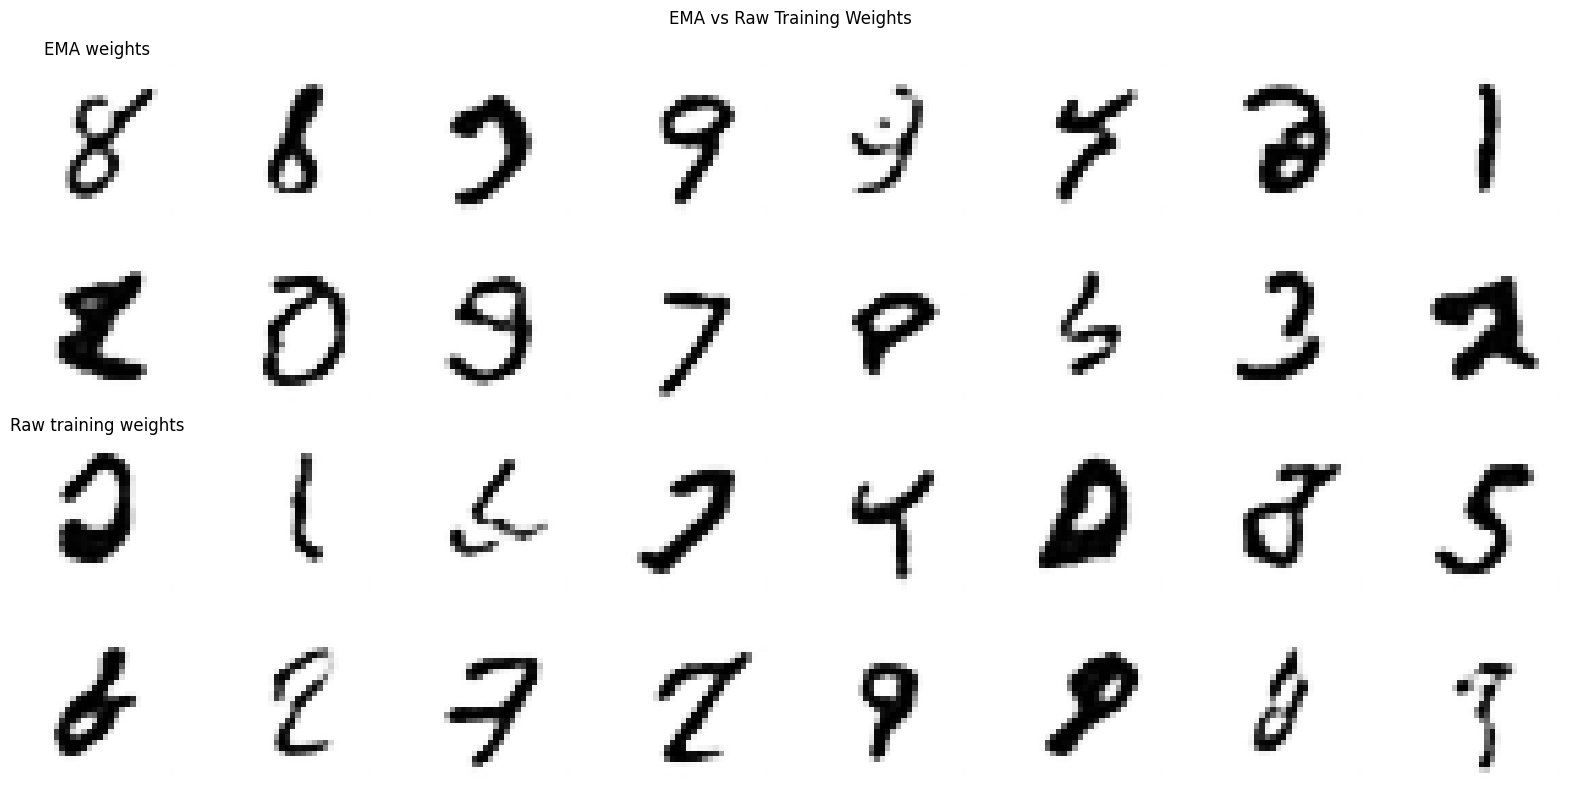

In [15]:
# Generate with EMA weights (already loaded)
gen_ema = sample(
    diff_model, model_AE,
    n_samples=16, T=T,
    n_tokens=model_AE.n_tokens,
    token_dim=model_AE.token_dim,
    latent_mean=latent_mean,
    latent_std=latent_std,
    device=device,
)

# Swap in raw training weights and generate again
diff_model.load_state_dict(raw_state)
gen_raw = sample(
    diff_model, model_AE,
    n_samples=16, T=T,
    n_tokens=model_AE.n_tokens,
    token_dim=model_AE.token_dim,
    latent_mean=latent_mean,
    latent_std=latent_std,
    device=device,
)

# Compare side by side
fig, axes = plt.subplots(4, 8, figsize=(16, 8))
for i in range(16):
    axes[i // 8, i % 8].imshow(gen_ema[i, 0].detach().cpu(), cmap='Greys')
    axes[i // 8, i % 8].axis('off')
for i in range(16):
    axes[2 + i // 8, i % 8].imshow(gen_raw[i, 0].detach().cpu(), cmap='Greys')
    axes[2 + i // 8, i % 8].axis('off')
axes[0, 0].set_title('EMA weights')
axes[2, 0].set_title('Raw training weights')
plt.suptitle('EMA vs Raw Training Weights')
plt.tight_layout()

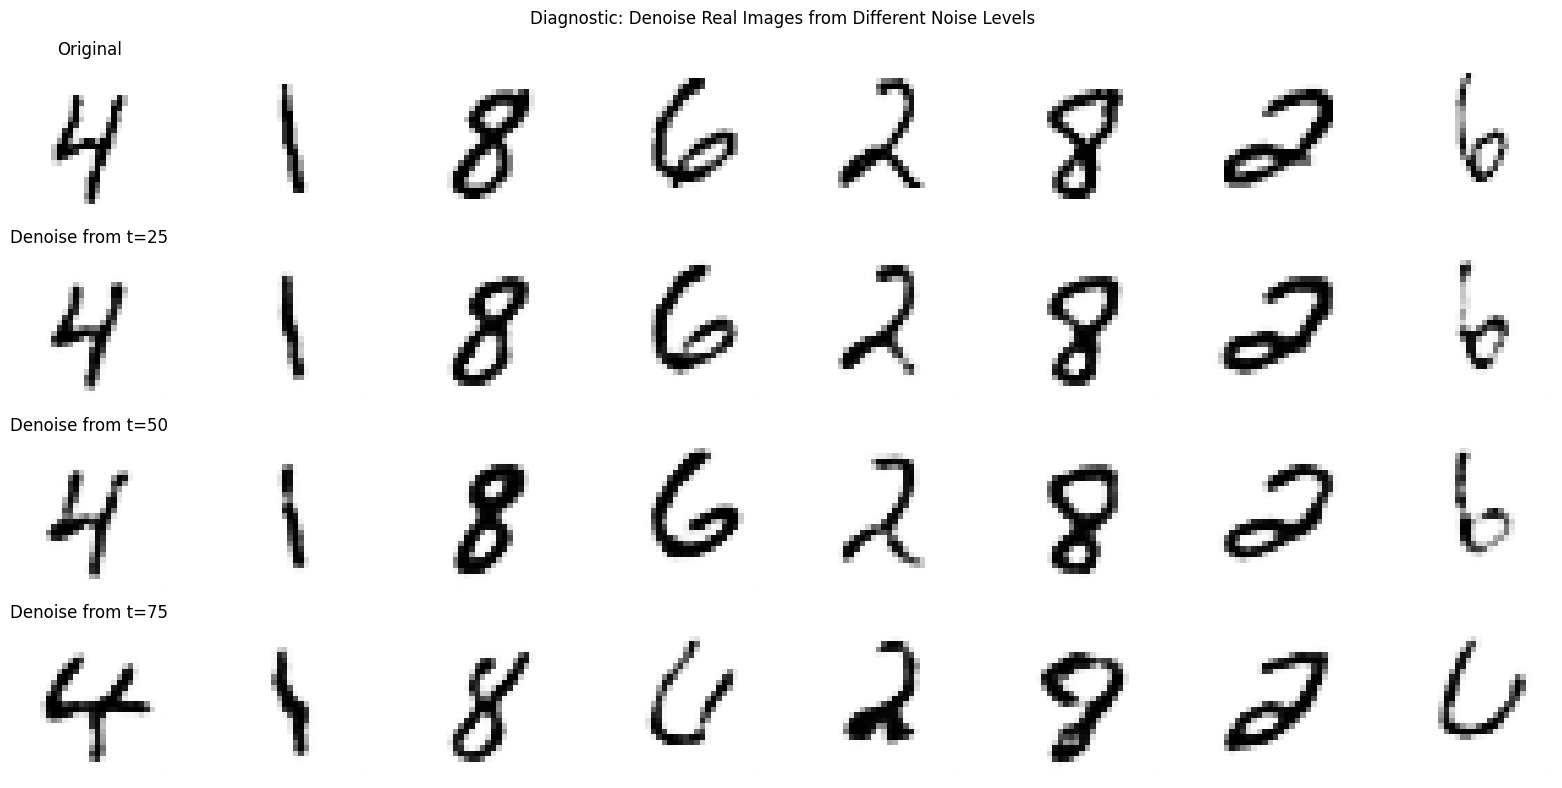

In [16]:
# DIAGNOSTIC: Can the model denoise a real image?
# If this works but pure sampling doesn't → the issue is starting from pure noise
# (i.e., the AE latent space is too non-Gaussian for the diffusion prior)
from diffusion import corrupt, compute_alpha_bar

diff_model.eval()
model_AE.eval()
betas, alphas, alpha_bar = compute_alpha_bar(T, device=device)

with torch.no_grad():
    # Take real images and encode them
    x_real, _ = next(iter(diff_dataloader))
    x_real = x_real[:8].to(device)
    z0 = model_AE.encode(x_real)
    z0_norm = (z0 - latent_mean.to(device)) / latent_std.to(device)

    # Noise them to different levels and denoise back
    fig, axes = plt.subplots(4, 8, figsize=(16, 8))

    # Row 0: original images
    for i in range(8):
        axes[0, i].imshow(x_real[i, 0].cpu(), cmap='Greys')
        axes[0, i].axis('off')
    axes[0, 0].set_title('Original')

    # Row 1: denoise from t=25 (light noise)
    # Row 2: denoise from t=50 (medium noise)
    # Row 3: denoise from t=75 (heavy noise)
    for row, start_t in enumerate([25, 50, 75], start=1):
        t_batch = torch.full((8,), start_t, device=device, dtype=torch.long)
        zt, _ = corrupt(z0_norm, t_batch, alpha_bar)

        # Run reverse process from start_t down to 0
        z = zt.clone()
        for t_step in range(start_t, -1, -1):
            t_vec = torch.full((8,), t_step, device=device, dtype=torch.long)
            eps_pred = diff_model(z, t_vec)
            coeff = betas[t_step] / torch.sqrt(1 - alpha_bar[t_step])
            mean = (1 / torch.sqrt(alphas[t_step])) * (z - coeff * eps_pred)
            if t_step > 0:
                z = mean + torch.sqrt(betas[t_step]) * torch.randn_like(mean)
            else:
                z = mean

        # Decode
        z_denorm = z * latent_std.to(device) + latent_mean.to(device)
        imgs = torch.sigmoid(model_AE.decode(z_denorm))
        for i in range(8):
            axes[row, i].imshow(imgs[i, 0].cpu(), cmap='Greys')
            axes[row, i].axis('off')
        axes[row, 0].set_title(f'Denoise from t={start_t}')

    plt.suptitle('Diagnostic: Denoise Real Images from Different Noise Levels')
    plt.tight_layout()